In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm , trange


In [2]:
torch.__version__

'2.6.0+cu124'

In [3]:
torchvision.__version__

'0.21.0+cu124'

In [83]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [84]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

In [103]:
batch_size=128
epochs=10
lr=3e-4
patch_size=4
num_classes=10
image_size=32
channels=3
embed_dim=256
num_heads=8
depth=6
mlp_dim=512
drop_rate=0.1

In [104]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))])

In [105]:
train_dataset=datasets.CIFAR10(root="./data",train=True,download=True,transform=transform)
test_dataset=datasets.CIFAR10(root="./data",train=False,download=True,transform=transform)

In [106]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [107]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [108]:
train_loader=DataLoader(dataset=train_dataset,shuffle=True,batch_size=batch_size)
test_loader=DataLoader(dataset=test_dataset,shuffle=False,batch_size=batch_size)

## Building Vision Transformer Model From Scratch

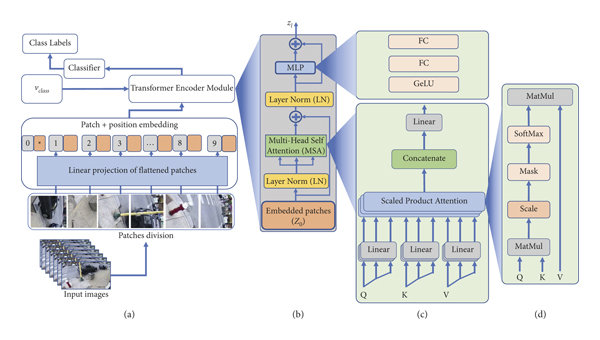

In [109]:
class PatchEmbedding(nn.Module):
  def __init__(self,image_size,patch_size,in_channels,embed_dim):
    super().__init__()
    self.patch_size=patch_size
    self.proj=nn.Conv2d(in_channels,out_channels=embed_dim,kernel_size=patch_size,stride=patch_size)
    num_patches=(image_size // patch_size)**2
    self.cls_token=nn.Parameter(torch.randn(1,1,embed_dim))
    self.pos_embed=nn.Parameter(torch.randn(1,1+num_patches,embed_dim))

  def forward(self,x: torch.tensor):
    B=x.size(0)
    x=self.proj(x) # [B,embed_dim,H/patch_size,W/patch_size]
    x=x.flatten(2).transpose(1,2)
    cls_token=self.cls_token.expand(B,-1,-1)
    x=torch.cat((cls_token,x),dim=1)
    x=x+self.pos_embed
    return x

In [110]:
class MLP(nn.Module):
  def __init__(self,in_features,
               hidden_features,
               drop_rate):

    super().__init__()
    self.fc1=nn.Linear(in_features=in_features,out_features=hidden_features)
    self.fc2=nn.Linear(in_features=hidden_features,out_features=in_features)
    self.dropout=nn.Dropout(p=drop_rate)

  def forward(self,x):
    x=self.dropout(F.gelu(self.fc1(x)))
    x=self.dropout(self.fc2(x))
    return x

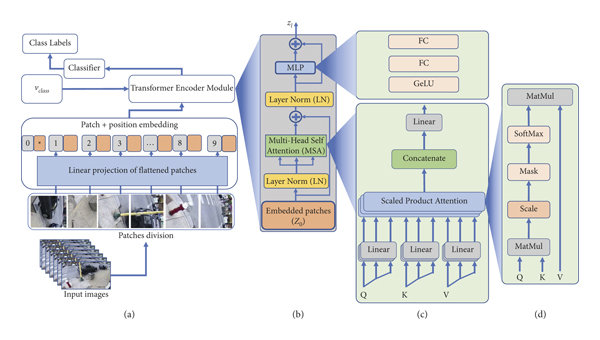

In [111]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,embed_dim,num_heads,mlp_dim,drop_rate):
    super().__init__()
    self.norm1=nn.LayerNorm(embed_dim)
    self.atten=nn.MultiheadAttention(embed_dim,num_heads,dropout=drop_rate,batch_first=True)
    self.norm2=nn.LayerNorm(embed_dim)
    self.mlp=MLP(embed_dim,mlp_dim,drop_rate)

  def forward(self,x):
    x=x+self.atten(self.norm1(x),self.norm1(x),self.norm1(x))[0]
    x=x+self.mlp(self.norm2(x))
    return x


In [112]:
class VisionTransformer(nn.Module):
  def __init__(self,image_size,patch_size,in_channels,num_classes,embed_dim,depth,num_heads,mlp_dim,drop_rate):
    super().__init__()
    self.patch_embed=PatchEmbedding(image_size,patch_size,in_channels,embed_dim)
    self.encoder=nn.Sequential(*[TransformerEncoderLayer(embed_dim,num_heads,mlp_dim,drop_rate)
    for _ in range(depth)
    ])
    self.norm=nn.LayerNorm(embed_dim)
    self.head=nn.Linear(embed_dim,num_classes)
  def forward(self,x):
    x=self.patch_embed(x)
    x=self.encoder(x)
    x=self.norm(x)
    cls_token=x[:,0]
    return self.head(cls_token)

In [113]:
model=VisionTransformer(image_size,patch_size,channels,num_classes,embed_dim,depth,num_heads,
                        mlp_dim,drop_rate).to(device)

In [114]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (atten): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (atten): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): M

In [115]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

In [116]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0

    for  x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)


In [117]:
def evaluate(model,loader):
  model.eval()
  correct=0
  with torch.no_grad():
    for  x,y  in loader :
      x,y=x.to(device),y.to(device)
      output=model(x)
      correct+=(output.argmax(dim=1)==y).sum().item()
  return correct/len(loader.dataset )

In [118]:
## Training
train_accuracy=[]
test_accuracy=[]


for i in trange(epochs,desc="Epoch"):
  train_loss , train_acc =train(model,train_loader,optimizer,criterion)
  test_acc=evaluate(model,test_loader)
  train_accuracy.append(train_acc)
  test_accuracy.append(test_acc)
  print(f"\n Epoch: {i+1}/{epochs}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")

Epoch:  10%|█         | 1/10 [00:49<07:28, 49.84s/it]


 Epoch: 1/10, Train loss: 1.7328, Train acc: 0.3720%, Test acc: 0.4717


Epoch:  20%|██        | 2/10 [01:38<06:32, 49.05s/it]


 Epoch: 2/10, Train loss: 1.3973, Train acc: 0.4964%, Test acc: 0.5269


Epoch:  30%|███       | 3/10 [02:27<05:43, 49.04s/it]


 Epoch: 3/10, Train loss: 1.2424, Train acc: 0.5571%, Test acc: 0.5659


Epoch:  40%|████      | 4/10 [03:16<04:54, 49.03s/it]


 Epoch: 4/10, Train loss: 1.1368, Train acc: 0.5943%, Test acc: 0.5783


Epoch:  50%|█████     | 5/10 [04:05<04:04, 48.96s/it]


 Epoch: 5/10, Train loss: 1.0464, Train acc: 0.6265%, Test acc: 0.5988


Epoch:  60%|██████    | 6/10 [04:53<03:15, 48.89s/it]


 Epoch: 6/10, Train loss: 0.9659, Train acc: 0.6563%, Test acc: 0.6090


Epoch:  70%|███████   | 7/10 [05:42<02:26, 48.85s/it]


 Epoch: 7/10, Train loss: 0.8951, Train acc: 0.6815%, Test acc: 0.6308


Epoch:  80%|████████  | 8/10 [06:31<01:37, 48.87s/it]


 Epoch: 8/10, Train loss: 0.8255, Train acc: 0.7068%, Test acc: 0.6181


Epoch:  90%|█████████ | 9/10 [07:22<00:49, 49.62s/it]


 Epoch: 9/10, Train loss: 0.7501, Train acc: 0.7323%, Test acc: 0.6330


Epoch: 100%|██████████| 10/10 [08:15<00:00, 49.54s/it]


 Epoch: 10/10, Train loss: 0.6803, Train acc: 0.7583%, Test acc: 0.6381


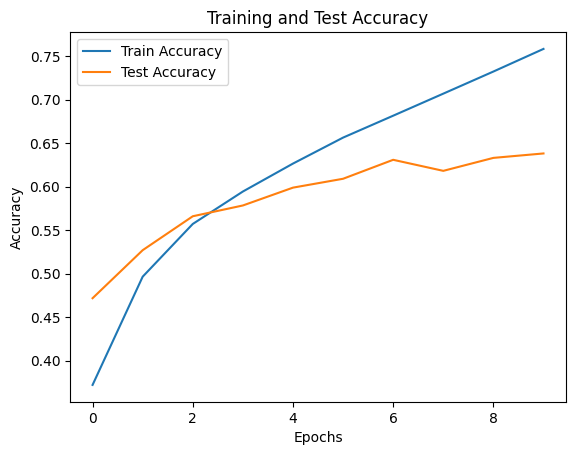

In [119]:
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()
